In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

# makes the figures higher quality.
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

plt.style.use("markerr.mplstyle")

In [2]:
from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.library.parameters import Season
from nba_api.stats.library.parameters import SeasonType
from nba_api.stats.endpoints import teamdashboardbyshootingsplits



In [16]:
team_colors = {
    'UTA':'#002B5C',# #753BBD OLD JAZZ PURPLE
    'TOR':'#CE1141',
    'ATL':'#E03A3E',
    'BOS':'#007A33',
    'BKN':'#000000',
    'CHA':'#1D1160',
    'CHI':'#CE1141',
    'CLE':'#860038',
    'DAL':'#00538C',
    'DEN':'#FEC524', # #0E2240 PRIMARY BLUE INSTEAD OF THE YELLOW PUT IN #0E2240
    'DET':'#C8102E',
    'GSW':'#1D428A', # #FFC72C THE YELLOW
    'HOU':'#CE1141',
    'IND':'#FDBB30', ##002D62 PACERS BLUE
    'LAC':'#C8102E', 
    'LAL':'#552583', 
    'MEM':'#5D76A9', 
    'MIA':'#98002E', 
    'MIL':'#00471B', 
    'MIN':'#0C2340', #236192 OTHER BLUE #9EA2A2 SILVER
    'NOP':'#0C2340', #C8102E RED #85714D GOLD
    'NYK':'#006BB6', #F58426 ORANGE
    'OKC':'#EF3B24', #EF3B24 orange # light blue #007AC1
    'ORL':'#0077C0', #C4CED4 SILVER
    'PHI':'#006BB6', 
    'PHX':'#E56020', #1D1160 PURPLE
    'POR':'#E03A3E', 
    'SAC':'#5A2D81',
    'SAS':'#C4CED4', 
    'WAS':'#002B5C' #E31837 RED
}

In [4]:

def add_legend(ax_, nba_teams_, home_team_, away_team_, home_color_, away_color_, fgm_bar_color_):
    home_team_name = [team for team in nba_teams_ if team['abbreviation']== home_team_][0]['full_name']
    away_team_name = [team for team in nba_teams_ if team['abbreviation']== away_team_][0]['full_name']
    home_patch = mpatches.Patch(color=home_color_,
                    label=f'{home_team_name} vs.')
    away_patch = mpatches.Patch(color=away_color_, 
                    label=f'{away_team_name}')
    fgm_patch = Line2D([0], [0], color=fgm_bar_color_, 
        label=f'Field Goals Made',lw=3)
    ax_.legend(handles=[home_patch,away_patch,fgm_patch],
        loc='center left', 
        bbox_to_anchor=(-0.03, 1.1),frameon=False,ncol=2,
                title = '',fontsize= 'large')
    return home_team_name, away_team_name

def add_bar_annotate(g_, ax_, df_, color_):
    for i,p in enumerate(g_.patches):
        fgm = int(df_.loc[i,'FGM'])
        fga = int(df_.loc[i,'FGA'])
        efg = round(df_.loc[i,'EFG_PCT']*100,1)
        fgm_a = f'{fgm} for {fga} ({efg}% eFG)'
        x = p.get_x() + p.get_width()+.5
        y = p.get_y() + p.get_height()/2
        ax_.annotate(fgm_a, (x, y), 
                    color = 'black',
                verticalalignment='center',)
        ax_.plot([fgm ,fgm],
            [p.get_y(),p.get_y()+p.get_height()],color = color_, lw= 3)

def add_author_line(fig_, ax_, left_text, right_text, color_, pad_left_weight = .5, pad_right_weight = .5):
    chartBox = ax_.get_position()
    x0, y0, x1, y1 = chartBox.x0, chartBox.y0, chartBox.x1, chartBox.y1
    pad_left = (fig_.get_figwidth()*x0*pad_left_weight)
    pad_right = (1-x1)*fig_.get_figwidth()*pad_right_weight
    ax_.annotate('', xy=(-pad_left, -0.05), xycoords='axes fraction', xytext=(1+pad_right, -0.05), color = color_,
        arrowprops=dict(arrowstyle='-', color=color_))
    ax_.annotate(left_text, xy = (1+pad_left, -0.1), xycoords='axes fraction', 
        xytext = (-pad_left, -0.1), horizontalalignment = 'left', color = color_,
            arrowprops=dict(arrowstyle='-', color='white'))
    ax_.annotate(right_text, xy = (1+pad_right, -0.1), xycoords='axes fraction', 
        xytext = (1+pad_right, -0.1), horizontalalignment = 'right', color = color_,
            arrowprops=dict(arrowstyle='-', color='white'))

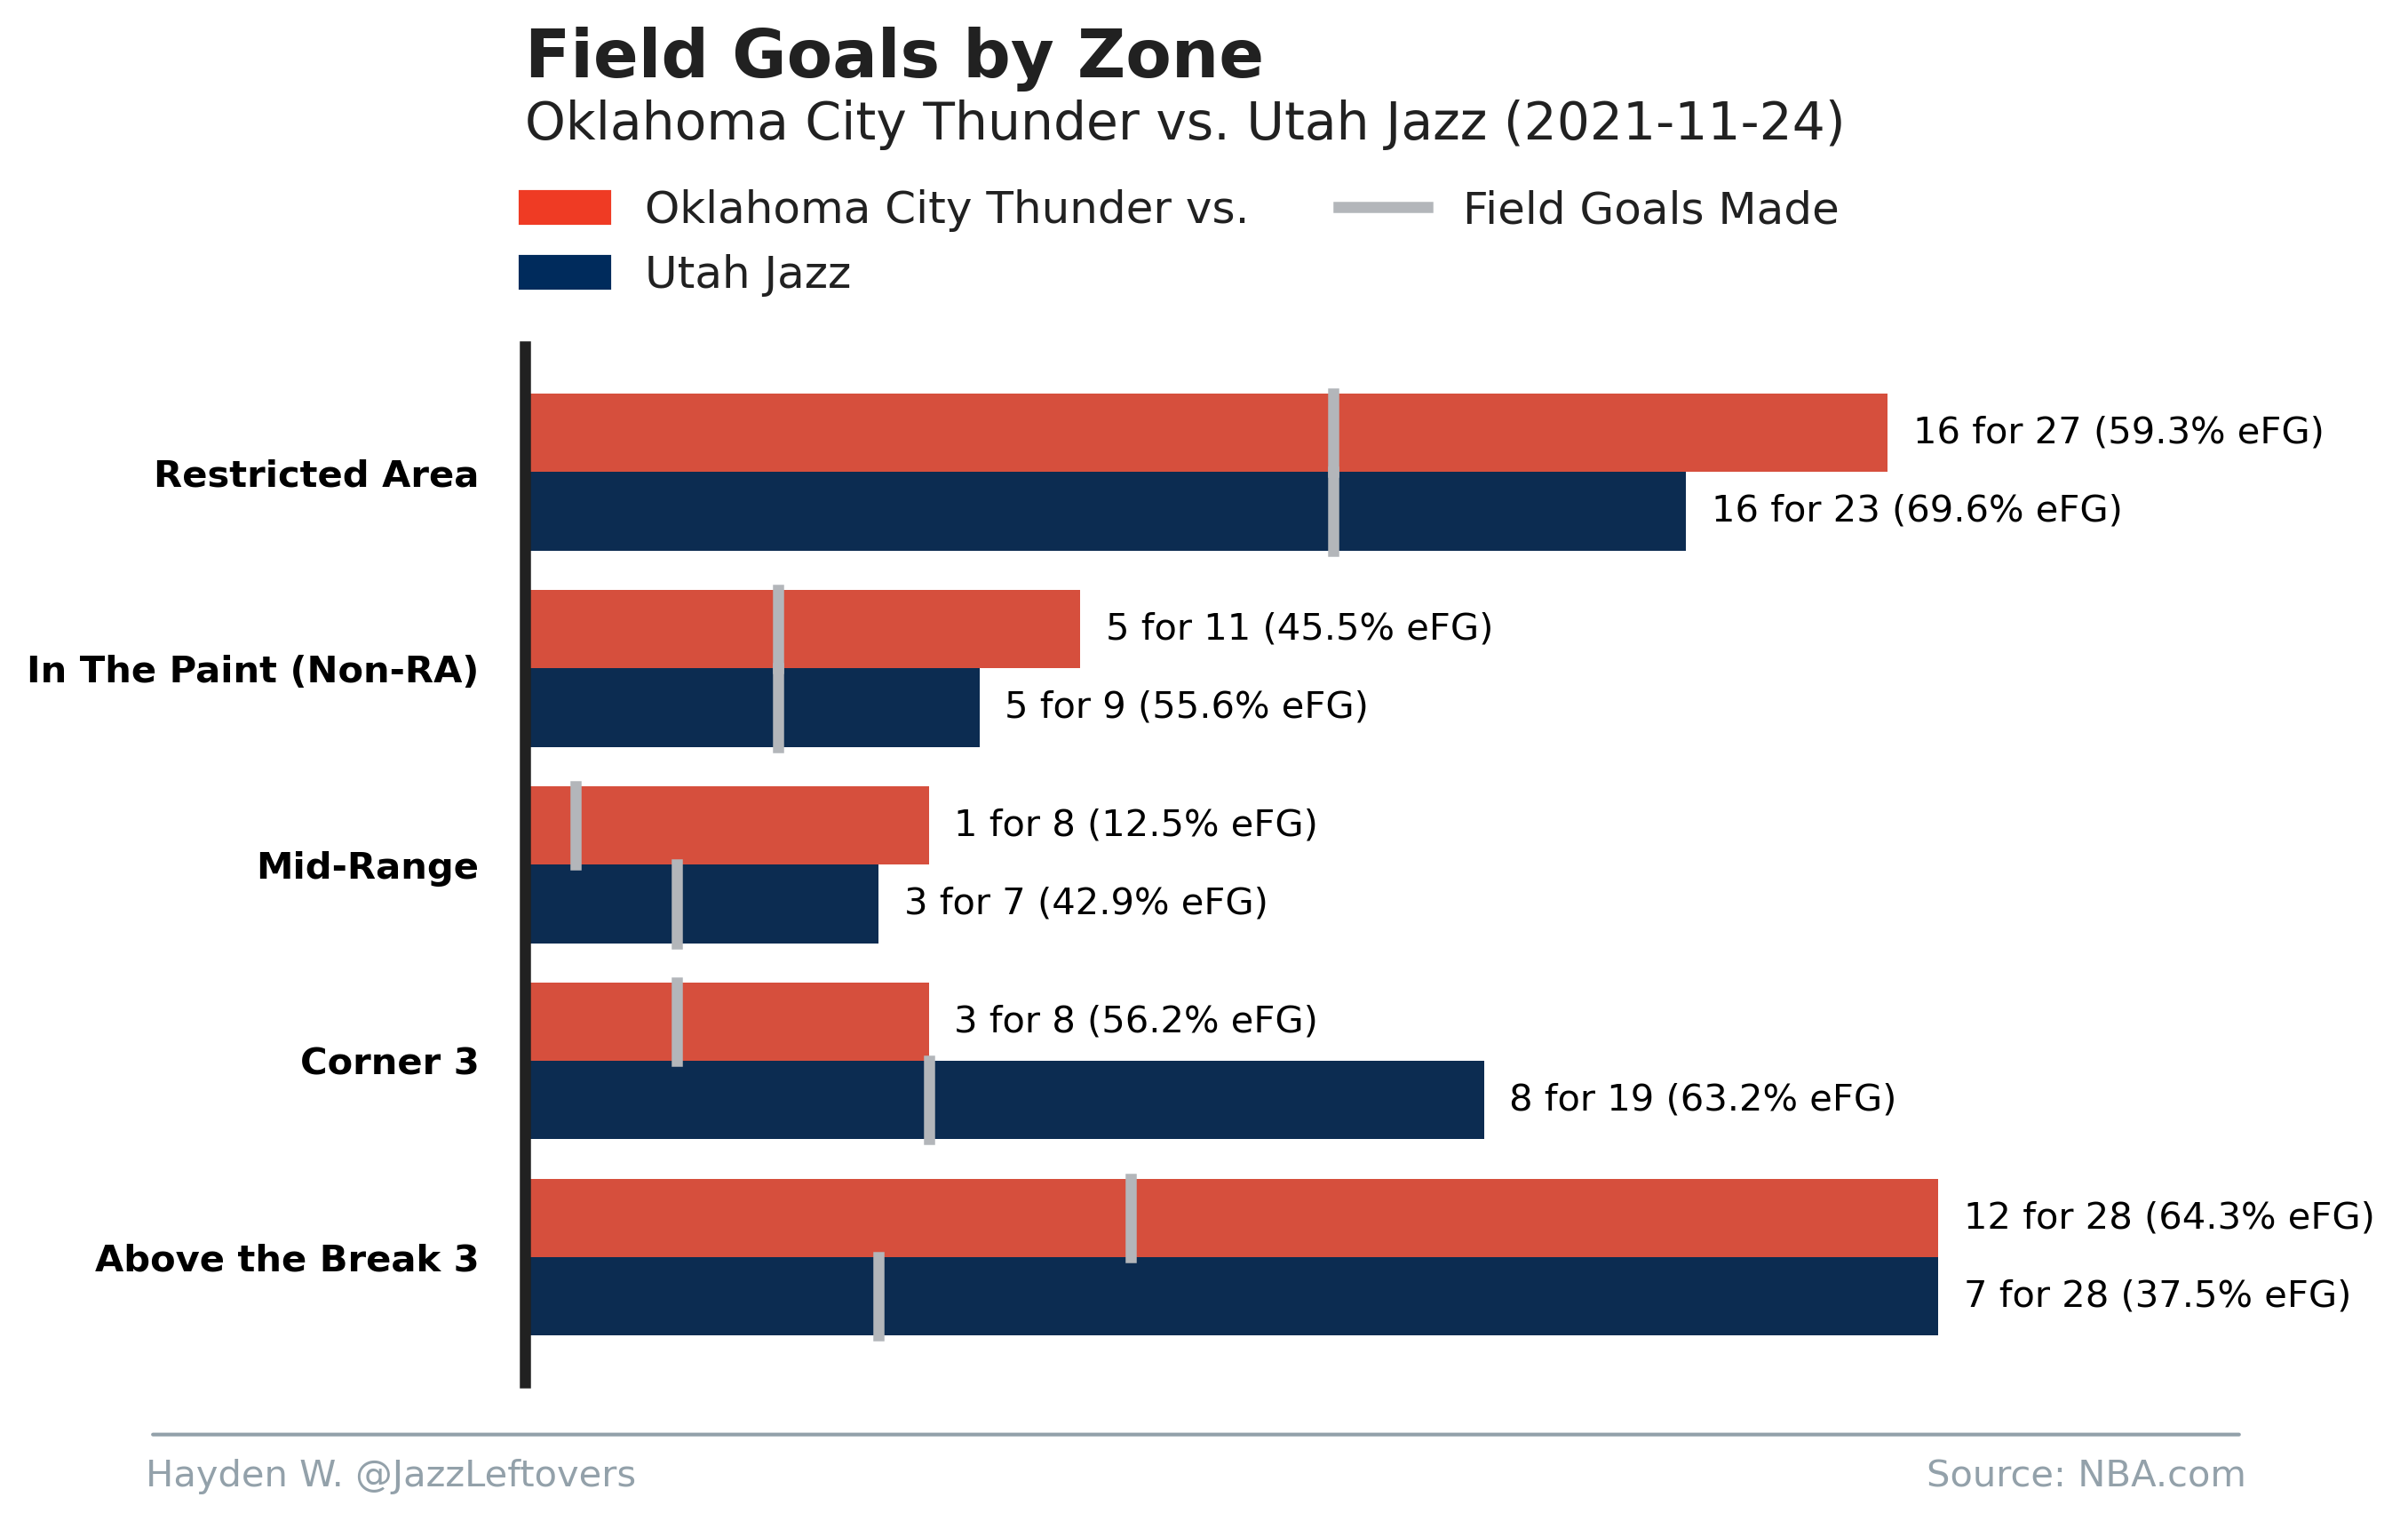

In [17]:
nba_teams = teams.get_teams()
jazz = [team for team in nba_teams if team['abbreviation']== 'UTA'][0]['id']
gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=jazz,
                            season_nullable=Season.default,
                            season_type_nullable=SeasonType.regular)  
games_dict = gamefinder.get_normalized_dict()
games = games_dict['LeagueGameFinderResults']

for game_num in range(len(games[:1])):
    game = games[game_num]
    game_day = game['GAME_DATE']
    game_matchup = game['MATCHUP']
    try:
        home_team, away_team = game_matchup.split(' vs. ')
    except ValueError:
        away_team, home_team = game_matchup.split(' @ ')
    away_team_dict = [team for team in nba_teams if team['abbreviation']== away_team][0]
    home_team_dict = [team for team in nba_teams if team['abbreviation']== home_team][0]
    away_team_id = away_team_dict['id']
    home_team_id = home_team_dict['id']    
    away_team_full_name = away_team_dict['full_name']
    home_team_full_name = home_team_dict['full_name']
    home_color = team_colors[home_team]
    away_color = team_colors[away_team]
    home_team_shots = teamdashboardbyshootingsplits.TeamDashboardByShootingSplits(team_id = home_team_id,
        date_from_nullable = game_day,
        date_to_nullable = game_day).get_data_frames()[3]
    away_team_shots = teamdashboardbyshootingsplits.TeamDashboardByShootingSplits(team_id = away_team_id,
        date_from_nullable = game_day,
        date_to_nullable = game_day).get_data_frames()[3]
    away_team_shots.loc[:,'TEAM_NAME'] = away_team_full_name
    away_team_shots.loc[3, 'GROUP_VALUE'] = 'Corner 3'
    fgm_corner_3 = away_team_shots.loc[3, 'FGM'] + away_team_shots.loc[4, 'FGM']
    fga_corner_3 = away_team_shots.loc[3, 'FGA'] + away_team_shots.loc[4, 'FGA']
    away_team_shots.loc[3, 'FGM'] = fgm_corner_3
    away_team_shots.loc[3, 'FGA'] = fga_corner_3
    away_team_shots.loc[3, 'EFG_PCT'] = (fgm_corner_3 * 3)/(fga_corner_3 * 2)
    away_team_shots = away_team_shots.drop([4,6]).reset_index(drop = True)

    home_team_shots.loc[:,'TEAM_NAME'] = home_team_full_name
    home_team_shots.loc[3, 'GROUP_VALUE'] = 'Corner 3'
    fgm_corner_3 = home_team_shots.loc[3, 'FGM'] + home_team_shots.loc[4, 'FGM']
    fga_corner_3 = home_team_shots.loc[3, 'FGA'] + home_team_shots.loc[4, 'FGA']
    home_team_shots.loc[3, 'FGM'] = fgm_corner_3
    home_team_shots.loc[3, 'FGA'] = fga_corner_3
    home_team_shots.loc[3, 'EFG_PCT'] = (fgm_corner_3 * 3)/(fga_corner_3 * 2)
    home_team_shots = home_team_shots.drop([4,6]).reset_index(drop = True)

    all_team_shots = pd.concat([home_team_shots,away_team_shots]).reset_index(drop = True)
    ## create graph, axes, figure
    fig, ax = plt.subplots()
    g = sns.barplot(data = all_team_shots, y = 'GROUP_VALUE',x = 'FGA', 
        hue = 'TEAM_NAME', palette=[home_color,away_color],
        ax = ax,orient='h')
    fgm_bar_color = '#B3B6BA'
    home_team_name, away_team_name = add_legend(ax, nba_teams, home_team, away_team, 
        home_color, away_color, fgm_bar_color)

    # solid black line at the bottom of graph
    ax.spines['left'].set_visible(True)
    # make the highlighted features bold. should be the same side with the visible spine
    plt.yticks(fontweight='bold')

    # removing clutter from labels and ticks
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticks([])
    # remove x axis grid lines that were cluttering the graph
    ax.grid(b = None, axis = 'y')
    ax.grid(b = None, axis = 'x')
    ax.grid(b = None, axis = 'y')

    ax.text(0, 1.26, "Field Goals by Zone", 
        transform=ax.transAxes, ha="left", fontsize = 18, fontweight = 'bold', color = '#212121')
    ax.text(0, 1.2, f'{home_team_name} vs. {away_team_name} ({game_day})', 
        transform=ax.transAxes, ha="left", fontsize = 14, color = '#212121')

    add_bar_annotate(g, ax, all_team_shots, fgm_bar_color)

    add_author_line(fig, ax, 'Hayden W. @JazzLeftovers', 'Source: NBA.com', '#93A1AA')

    plt.show()

In [ ]:
fig, ax = plt.subplots()
g = sns.barplot(data = all_team_shots, y = 'GROUP_VALUE',x = 'FGA', 
    hue = 'TEAM_NAME', palette=[home_color,away_color],
    ax = ax,orient='h')
fgm_bar_color = '#B3B6BA'
home_team_name, away_team_name = add_legend(ax, nba_teams, home_team, away_team, 
    home_color, away_color, fgm_bar_color)

# solid black line at the bottom of graph
ax.spines['left'].set_visible(True)
# make the highlighted features bold. should be the same side with the visible spine
plt.yticks(fontweight='bold')

# removing clutter from labels and ticks
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticks([])
# remove x axis grid lines that were cluttering the graph
ax.grid(b = None, axis = 'y')
ax.grid(b = None, axis = 'x')
ax.grid(b = None, axis = 'y')

ax.text(0, 1.26, "Field Goals by Zone", 
    transform=ax.transAxes, ha="left", fontsize = 18, fontweight = 'bold', color = '#212121')
ax.text(0, 1.2, f'{home_team_name} vs. {away_team_name} ({game_day})', 
    transform=ax.transAxes, ha="left", fontsize = 14, color = '#212121')

add_bar_annotate(g, ax, all_team_shots, fgm_bar_color)

add_author_line(fig, ax, 'Hayden W. @JazzLeftovers', 'Source: NBA.com', '#93A1AA')

plt.show()